In [7]:
# Author: Emerson Franzua Aldana Gavarrete

# Description:
# This code provides functions to compute and visualize various aspects of Fresnel coefficients.
# The functions are highly configurable, allowing users to adapt them to various needs through
# flexible input parameters. Refer to the docstrings for detailed explanations of the inputs
# and to understand how to customize the behavior of each function.

# Imported Libraries:
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For plotting and visualization
from scipy.constants import c, mu_0, epsilon_0  # Physical constants (speed of light, vacuum permeability, vacuum permittivity)

In [8]:
#This functions are essential for the other functions


def complex_refractive_index(sigma, mu, epsilon, frequency):
    """
    Calculate the complex refractive index for a given material.

    Parameters:
    - sigma (float): Electrical conductivity of the material (S/m).
    - mu (float): Permeability of the material (H/m).
    - epsilon (float): Permittivity of the material (F/m).
    - frequency (float): Frequency of the electromagnetic wave (Hz).

    Returns:
    - complex: The complex refractive index (n_r + n_i * 1j).

    Notes:
    The formula is derived from electromagnetic wave propagation equations
    and uses the relationship between conductivity, permittivity, and permeability.
    """
    omega = 2 * np.pi * frequency  # Angular frequency
    X = (sigma / (epsilon * omega))**2

    n_r = c * np.sqrt(mu * epsilon / 2) * np.sqrt(np.sqrt(1 + X) + 1)
    n_i = c * np.sqrt(mu * epsilon / 2) * np.sqrt(np.sqrt(1 + X) - 1)

    return n_r + n_i * 1j


#This is function is useful for programming logic, but useless for the user.
def filter_angle(theta_input, nit, is_dg=False, tolerance=1e-5):
    """
    Filter the angles to determine which are real and which are complex.

    Parameters:
    - theta_input (array-like): Incident angles (in degrees or radians).
    - nit (list or tuple): Refractive indices of the two media [n_i, n_t].
      n_i is the refractive index of the incident medium, and
      n_t is the refractive index of the transmitted medium.
    - is_dg (bool): If True, interpret theta_input as degrees and convert to radians. Default is False.
    - tolerance (float): Threshold to consider the imaginary part negligible. Default is 1e-5.

    Returns:
    - mask (array): Boolean array indicating which angles are real.
    - theta_t (array): Array of transmitted angles (complex if necessary).
    """
    theta_input = np.array(theta_input)

    # Restrict to physical range: [0, 90°] or [0, π/2 rad]
    if is_dg:
        theta_input = theta_input[(theta_input >= 0) & (theta_input <= 90)]
        theta_input = theta_input * np.pi / 180  # Convert to radians
    else:
        theta_input = theta_input[(theta_input >= 0) & (theta_input <= np.pi / 2)]

    n_i, n_t = nit  

    theta_i = np.array(theta_input, dtype=complex)  # Ensure input is treated as complex
    theta_t = np.arcsin(n_i * np.sin(theta_i) / n_t)  # Snell's Law

    # Mask for real angles (imaginary part below tolerance)
    mask = np.abs(theta_t.imag) < tolerance

    return mask, theta_t

#This is a new logarithmic cut branch to reflect negative coeficients.
import numpy as np

def fm_complex(z, main=True):
    """
    Decompose a complex number into its adjusted amplitude and phase.

    Parameters:
    - z (complex): The complex number to decompose.
    - use_usual_branch (bool): Whether to use the usual branch for the argument (phase).
        If True, the phase is not adjusted and will be within [-pi, pi].

    Returns:
    - amplitude (float): The amplitude of the complex number.
    - phase (float): The phase of the complex number.

    Notes:
    - If use_usual_branch is False, the phase is constrained within [-pi/2, pi/2].
    - If use_usual_branch is True, the phase is returned in the standard range of [-pi, pi].
    """
    amplitude = np.abs(z)  # Calculate amplitude (magnitude)
    phase = np.angle(z)  # Calculate phase (angle in radians)

    if not main:
        # Adjust phase and amplitude for values outside the range [-pi/2, pi/2]
        mask_positive = phase >= np.pi / 2
        mask_negative = phase <= -np.pi / 2

        phase = np.where(mask_positive, phase-np.pi, phase)
        amplitude = np.where(mask_positive, -amplitude, amplitude)

        phase = np.where(mask_negative, -np.pi - phase, phase)
        amplitude = np.where(mask_negative, -amplitude, amplitude)

    return amplitude, phase

In [9]:

def fresnel(theta_input, nit, is_dg=False):
    """
    Compute the complex Fresnel amplitude coefficients for s- and p-polarized light 
    at an interface between two media.

    Parameters:
    -----------
    theta_input : float or array_like
        Angle(s) of incidence in radians (unless is_dg=True, then in degrees).
    nit : tuple (n_i, n_t)
        Refractive indices of incident medium n_i and transmitted medium n_t.
        Can be real or complex.
    is_dg : bool, default False
        If True, theta_input is interpreted (and converted) in degrees.

    Returns:
    --------
    r_s : complex ndarray
        Reflection amplitude coefficient for s-polarization.
    r_p : complex ndarray
        Reflection amplitude coefficient for p-polarization.
    t_s : complex ndarray
        Transmission amplitude coefficient for s-polarization.
    t_p : complex ndarray
        Transmission amplitude coefficient for p-polarization.

    Notes:
    ------
    Uses Snell’s law: n_i*sin(theta_i) = n_t*sin(theta_t),
    and standard Fresnel formulae:
      r_s = (n_i cosθ_i - n_t cosθ_t)/(n_i cosθ_i + n_t cosθ_t)
      r_p = (n_t cosθ_i - n_i cosθ_t)/(n_t cosθ_i + n_i cosθ_t)
      t_s = 2 n_i cosθ_i/(n_i cosθ_i + n_t cosθ_t)
      t_p = 2 n_i cosθ_i/(n_t cosθ_i + n_i cosθ_t)
    """
    if is_dg:
        theta_input = theta_input * np.pi / 180

    n_i, n_t = nit
    n_i = complex(n_i)
    n_t = complex(n_t)
    theta_i = np.array(theta_input, dtype=complex)

    # Snell's law
    sin_theta_t = n_i * np.sin(theta_i) / n_t
    cos_theta_t = np.sqrt(1 - sin_theta_t**2)

    # Fresnel amplitude coefficients
    r_s = (n_i * np.cos(theta_i) - n_t * cos_theta_t) / (n_i * np.cos(theta_i) + n_t * cos_theta_t)
    r_p = (n_t * np.cos(theta_i) - n_i * cos_theta_t) / (n_t * np.cos(theta_i) + n_i * cos_theta_t)
    t_s = 2 * n_i * np.cos(theta_i) / (n_i * np.cos(theta_i) + n_t * cos_theta_t)
    t_p = 2 * n_i * np.cos(theta_i) / (n_t * np.cos(theta_i) + n_i * cos_theta_t)

    return r_s, r_p, t_s, t_p


def ene_coef(theta_input, nit, is_dg=False):
    """
    Compute the power (energy) reflectance and transmittance for s- and p-polarizations.

    Parameters:
    -----------
    theta_input : float or array_like
        Angle(s) of incidence in radians (unless is_dg=True, then in degrees).
    nit : tuple (n_i, n_t)
        Refractive indices of incident medium n_i and transmitted medium n_t.
    is_dg : bool, default False
        If True, theta_input is interpreted in degrees.

    Returns:
    --------
    R_s : float or ndarray
        Reflectance (power ratio) for s-polarized light = |r_s|².
    R_p : float or ndarray
        Reflectance for p-polarized light = |r_p|².
    T_s : float or ndarray
        Transmittance for s-polarized light = |t_s|² * Re[n_t cosθ_t / (n_i cosθ_i)].
    T_p : float or ndarray
        Transmittance for p-polarized light = |t_p|² * Re[n_t cosθ_t / (n_i cosθ_i)].

    Notes:
    ------
    Only the real part of T_s and T_p is shown because only real power flow (from the real part of the Poynting vector)
    is physically meaningful. This is essential when dealing with complex refractive indices (e.g., metals),
    where full expressions for T may be complex, but only the real part represents actual transmitted energy.
    """

    r_s, r_p, t_s, t_p = fresnel(theta_input, nit, is_dg)

    if is_dg:
        theta_input = theta_input * np.pi / 180

    n_i, n_t = nit
    n_i = complex(n_i)
    n_t = complex(n_t)
    theta_i = np.array(theta_input, dtype=complex)

    # Snell's law
    sin_theta_t = n_i * np.sin(theta_i) / n_t
    cos_theta_t = np.sqrt(1 - sin_theta_t**2)

    # Power coefficients
    R_s = np.abs(r_s)**2
    R_p = np.abs(r_p)**2
    T_s = np.abs(t_s)**2 * np.real(n_t * cos_theta_t / (n_i * np.cos(theta_i)))
    T_p = np.abs(t_p)**2 * np.real(n_t * cos_theta_t / (n_i * np.cos(theta_i)))
    #

    return R_s, R_p, T_s, T_p


In [10]:
def plot_frenel(theta_input, nit, plot_which=[True, True, True, True], angle_rad=[False,False],main=True):
    """
    Plot the magnitude and phase of Fresnel reflection and transmission coefficients.

    Parameters:
    -----------
    theta_input : array_like
        Incidence angles (in degrees or radians).
    nit : complex
        Relative complex refractive index n2/n1.
    plot_which : list of bool
        List indicating which coefficients to plot: [r_s, r_p, t_s, t_p].
    angle_rad : list of bool
        [is_input_in_degrees, show_plot_in_degrees].
    main : bool
        If True, take only the real part of power-related quantities for physical interpretation.

    Notes:
    ------
    Only the real part of transmission coefficients is used when `main=True`,
    since only the real part contributes to energy transmission.
    """
    is_dg, plot_degree = angle_rad

    # Compute transmitted angles and valid mask
    mask, theta_t = filter_angle(theta_input, nit, is_dg, tolerance=1e-5)
    
    # Compute Fresnel reflection and transmission coefficients
    r_s, r_p, t_s, t_p = fresnel(theta_input, nit, is_dg)

    # Compute magnitudes and phases
    coef = np.array([fm_complex(r_s, main)[0], fm_complex(r_p, main)[0],
                     fm_complex(t_s, main)[0], fm_complex(t_p, main)[0]])
    phase = np.array([fm_complex(r_s, main)[1], fm_complex(r_p, main)[1],
                      fm_complex(t_s, main)[1], fm_complex(t_p, main)[1]])
        
    names = ['$r_s$', '$r_p$', '$t_s$', '$t_p$']

    plt.figure()

    # Convert input angles if necessary
    if (plot_degree) & (not is_dg):
        theta_input = theta_input * 180 / np.pi
    if (not plot_degree) & (is_dg):
        theta_input = theta_input * np.pi / 100
    if plot_degree:
        phase = phase * 180 / np.pi  # Convert phase to degrees if requested

    # Plot magnitude of coefficients
    for i in range(len(plot_which)):
        if plot_which[i]:
            plt.plot(theta_input, coef[i], label=names[i])
    plt.grid(True)
    plt.xlabel('$\\theta_i$')
    plt.ylabel('$Fresnel \\ coeficients$')
    plt.legend()
    plt.title("Module of Fresnel-coeficients")
    plt.show()

    # Plot phase shifts
    plt.figure()
    for i in range(len(plot_which)):
        if plot_which[i]:
            plt.plot(theta_input, phase[i], label=names[i])
    plt.grid(True)
    plt.xlabel('$\\theta_i$')
    plt.ylabel('$\\Delta \\phi$')
    plt.title("Change of phase")
    plt.legend()
    plt.show()


def plot_ene(theta_input, nit, plot_which=[True, True, True, True], angle_rad=[False,False], main=True):
    """
    Plot reflectance and transmittance coefficients.

    Parameters:
    -----------
    theta_input : array_like
        Incidence angles (in degrees or radians).
    nit : complex
        Relative complex refractive index n2/n1.
    plot_which : list of bool
        List indicating which coefficients to plot: [R_s, R_p, T_s, T_p].
    angle_rad : list of bool
        [is_input_in_degrees, show_plot_in_degrees].
    main : bool
        Currently unused here, but included for consistency.

    Notes:
    ------
    Only the real part of transmission coefficients is shown when `main=True`.
    """
    is_dg, plot_degree = angle_rad

    # Compute transmitted angles and valid mask
    mask, theta_t = filter_angle(theta_input, nit, is_dg, tolerance=1e-5)
    
    # Compute reflectance and transmittance
    R_s, R_p, T_s, T_p = ene_coef(theta_input, nit, is_dg)

    # Extract magnitudes (real parts if needed)
    coef = np.array([fm_complex(R_s)[0], fm_complex(R_p)[0],
                     fm_complex(T_s)[0], fm_complex(T_p)[0]])
        
    names = ['$R_s$', '$R_p$', '$T_s$', '$T_p$']

    plt.figure()

    # Convert input angles if necessary
    if (plot_degree) & (not is_dg):
        theta_input = theta_input * 180 / np.pi
    if (not plot_degree) & (is_dg):
        theta_input = theta_input * np.pi / 100

    # Plot energy coefficients
    for i in range(len(plot_which)):
        if plot_which[i]:
            plt.plot(theta_input, coef[i], label=names[i])
    plt.grid(True)
    plt.xlabel('$\\theta_i$')
    plt.ylabel('$Reflectance/Transmitance$')
    plt.legend()
    plt.title("Reflectance/Transmitance")
    plt.show()



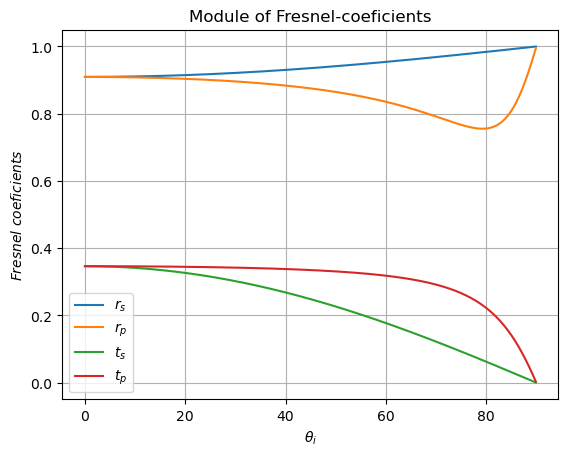

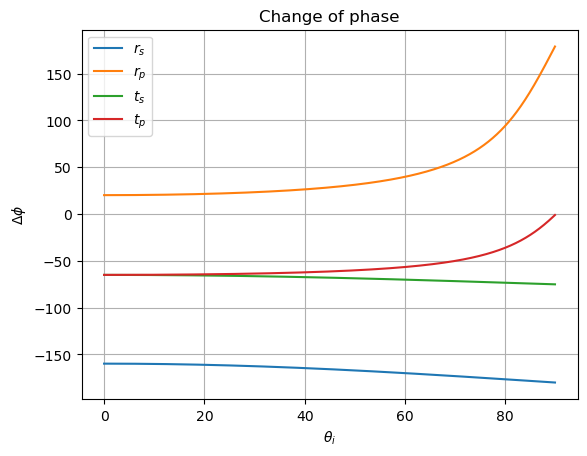

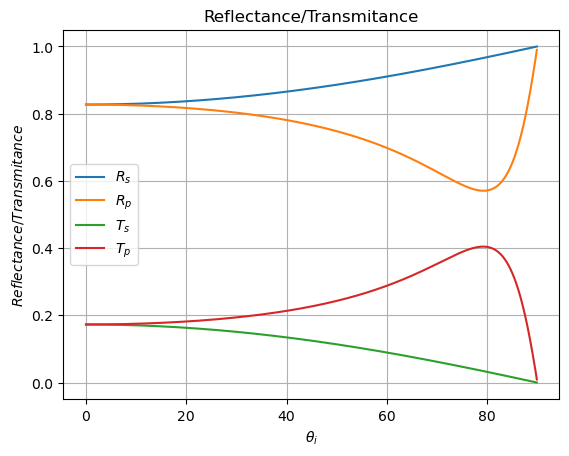

In [11]:
#Function Test
mu_0 = 4 * np.pi * 1e-7  # H/m (henries per meter)

epsilon_0 = 1 / (mu_0 * (299_792_458**2))  # F/m (farads per meter)

frequency = c/(550e-9)

mu = mu_0 * mu_r
epsilon = epsilon_0 * epsilon_r

n_a = complex_refractive_index(sigma, mu, epsilon, frequency)

theta_i = np.linspace(0, 89.9, 100000)  # degrees
nit = [1, 1.44+5.23j]  # Air to metal

plot_frenel(theta_i, nit, [True, True, True, True], [True, True])
plot_ene(theta_i, nit, [True, True, True, True], [True, True])
